# Dacon Competition Project : Predict Market Sales

## Data field
* store_id : 상점의 고유 아이디
* card_id : 사용한 카드의 고유 아이디
* card_company : 비식별화된 카드 회사
* transacted_date: 거래 날짜
* transacted_time : 거래 시간 (시:분)
* installment_term : 할부 개월 수( 포인트 사용 시 (60개월 + 실제할부개월)을 할부개월수에 기재한다. )
* region : 상점의 지역
* type_of_business:상점의 업종
* amount : 거래액(단위는 원이 아닙니다)

## Index
### Step1. Data Load & Resampling
* 시계열 분석을 위한 date index로 변환
* 시간 단위로 나뉘어져 있는 데이터를 일 단위로 resampling
* Modeling을 위해 월 단위로 resampling


In [1]:
# jupyter notebook cell 너비 조절
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 기본
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.externals import joblib 
from sklearn.metrics import make_scorer

# 시계열
from fbprophet import Prophet
from datetime import datetime as dt
from statsmodels.tsa.arima_model import ARIMA
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

# 회귀분석
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

# Deep Neural Network
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import time

# 설정
%matplotlib inline
pd.options.display.max_columns = 400
pd.options.display.float_format = '{:.5f}'.format


ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
pip install fbprophet

## Evaluate Metric
* MAE (Mean Absolute Error) : 절댓값 오차의 평균

$MAE=\frac{1}{𝑛}∑| 𝑦𝑖−𝑦̂𝑖|$
 
* validation을 위한 함수 생성 및 make scorer

In [3]:
def mae(prediction, correct):
    prediction = np.array(prediction)
    correct = np.array(correct)
    
    difference = correct - prediction
    abs_val = abs(difference)
    
    score = abs_val.mean()
    
    return score

mae_scorer = make_scorer(mae)
mae_scorer

make_scorer(mae)

## Issue
1) 예측해야 하는 범위는 3개월인데 데이터는 시간 단위로 나뉘어져 있음
* month 주기로 resampling 후 forecast 범위를 3개월로 지정하여 해결

2) 1967개의 store_id가 각각의 trend와 seasonality를 가지고 있음
* 같은 알고리즘에서 각 store_id별로 parameter를 조절한다.

3) 예측 날짜는 2019-03~2019-05로 동일하나, 제공 데이터의 마지막 날짜는 차이가 있다.
* 마지막 날짜부터 3개월만 예측하여 제출한다.(ex: store_id 111의 마지막 날짜는 2018-09월로 뒤 3개월인 2018-10~2018-12만 예측하여 제출)
* 예측 기간이 길어질수록 오차가 크게 발생하여 바로 뒤 3개월만 예측하는 것이 정확도가 높았음

# Step1. Data Load

In [4]:
df_train = pd.read_csv('./data/funda_train.csv')
df_sub = pd.read_csv('./data/submission.csv')
df_train['transacted_date'] = pd.to_datetime(df_train['transacted_date'])

print(df_train.shape)

(6556613, 9)


In [39]:
df_train['transacted_date'].dtype

dtype('<M8[ns]')

In [40]:
df_train.head()

,store_id,card_id,card_company,transacted_date,transacted_time,installment_term,region,type_of_business,amount
0,0,0,b,2016-06-01,13:13,0,NaN,기타 미용업,1857.142857
1,0,1,h,2016-06-01,18:12,0,NaN,기타 미용업,857.142857
2,0,2,c,2016-06-01,18:52,0,NaN,기타 미용업,2000.000000
3,0,3,a,2016-06-01,20:22,0,NaN,기타 미용업,7857.142857
4,0,4,c,2016-06-02,11:06,0,NaN,기타 미용업,2000.000000


In [19]:
# 각 컬럼의 유니크한 값이 몇개인지, 결측치 개수, 데이터타입, 유니크한 값 5개
### 아래 for문 풀어서 써보기 !
frame_info=[ ( col, len(df_train[col].unique()), df_train[col].isnull().sum(), df_train[col].dtype, df_train[col].unique()[:5] ) for col in df_train.columns]
df_info=pd.DataFrame(frame_info, columns=['name', 'num_of_unique', 'num_of_nan', 'type', 'front5_values'])
df_info

,name,num_of_unique,num_of_nan,type,front5_values
0,store_id,1967,0,int64,"[0, 1, 2, 4, 5]"
1,card_id,3950001,0,int64,"[0, 1, 2, 3, 4]"
2,card_company,8,0,object,"[b, h, c, a, f]"
3,transacted_date,1003,0,datetime64[ns],"[2016-06-01T00:00:00.000000000, 2016-06-02T00:..."
4,transacted_time,1440,0,object,"[13:13, 18:12, 18:52, 20:22, 11:06]"
5,installment_term,34,0,int64,"[0, 2, 3, 60, 4]"
6,region,181,2042766,object,"[nan, 서울 종로구, 충북 충주시, 부산 동래구, 경기 평택시]"
7,type_of_business,146,3952609,object,"[기타 미용업, nan, 의복 액세서리 및 모조 장신구 도매업, 한식 음식점업, 배..."
8,amount,30551,0,float64,"[1857.142857142857, 857.1428571428571, 2000.0,..."


### 시계열 분석을 위해 date 정보를 index로 변환

In [41]:
df_train = df_train.set_index('transacted_date')
df_train.head(3)

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.142857
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.000000


### 시간 단위로 나뉘어져 있는 데이터를 일단위로 resampling
* 'store_id', 'region', 'type_of_business' 기존과 동일
* day_of_week : 각 요일을 나타내는 숫자, 월요일은 0 일요일은 6
* business_day : working day 여부, 1이면 working day 0이면 주말
* num_of_pay : 일 결제 건수, 'card_id'의 count로 생성
* num_of_revisit : 단골 방문 횟수, 'card_id'의 value 중 count가 2보다 큰(3 이상) value의 결제 건수
* installment_term : 일 총 할부 개월 수, 기존 installment_term의 합
* amount : 일 매출 액, 기존 amount의 합

> 시간별 데이터를 일별로 카운트하고 싶을 때
* resample(rule='d').count( ) <br>

> 시간별 데이터를 일별로 합계를 구하고 싶을 때
* resample(rule='d').sum( )

In [49]:
df_train[df_train.store_id==0]

,store_id,card_id,card_company,transacted_time,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,
2016-06-01,0,0,b,13:13,0,NaN,기타 미용업,1857.142857
2016-06-01,0,1,h,18:12,0,NaN,기타 미용업,857.142857
2016-06-01,0,2,c,18:52,0,NaN,기타 미용업,2000.000000
2016-06-01,0,3,a,20:22,0,NaN,기타 미용업,7857.142857
2016-06-02,0,4,c,11:06,0,NaN,기타 미용업,2000.000000
...,...,...,...,...,...,...,...,...
2019-02-28,0,1476,a,12:17,0,NaN,기타 미용업,2857.142857
2019-02-28,0,1719,a,16:20,0,NaN,기타 미용업,6428.571429
2019-02-28,0,1791,b,16:56,0,NaN,기타 미용업,7142.857143


#### resample() 함수
    * resample('d') 는 '년-월-일 시간:분:초' 의 시계열 index를 1일 단위의 동일 간격별로 데이터를 뽑으라는 뜻
#### insert() 함수
    * insert(a, b)는 리스트의 a번째 위치에 b를 삽입하는 함수이다.
#### dayofweek
    * date정보를 index로 변환했기 때문에 
    * df_train.index.dayofweek를 하면 각 요일을 나타내는 숫자 출력됨

In [139]:
df_train.index.dayofweek

Int64Index([2, 2, 2, 2, 3, 3, 3, 3, 3, 3,
            ...
            3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
           dtype='int64', name='transacted_date', length=6556613)

In [69]:
df_train[df_train.store_id==0]['card_id'].resample(rule='d').count().rename('num_of_pay')

transacted_date
2016-06-01    4
2016-06-02    7
2016-06-03    3
2016-06-04    7
2016-06-05    3
             ..
2019-02-24    6
2019-02-25    6
2019-02-26    0
2019-02-27    5
2019-02-28    6
Freq: D, Name: num_of_pay, Length: 1003, dtype: int64

In [90]:
df_train[df_train.store_id==0].card_id.value_counts().reset_index().query("card_id >2")["index"].values[:10]

array([ 32, 855,  44, 669, 898, 138, 480, 560, 346, 595])

In [95]:
df_train[df_train.card_id.isin(df_train[df_train.store_id==0].card_id.value_counts().reset_index().query("card_id >2")["index"].values)].card_id

transacted_date
2016-06-01       0
2016-06-01       1
2016-06-01       2
2016-06-01       3
2016-06-02       4
              ... 
2018-04-28    1248
2017-10-04    1252
2017-12-22     117
2018-03-12     488
2017-02-11     707
Name: card_id, Length: 2877, dtype: int64

In [98]:
df_train[df_train.store_id==0][['installment_term','amount']].resample(rule='d').sum()

,installment_term,amount
transacted_date,,
2016-06-01,0,12571.428571
2016-06-02,0,40571.428571
2016-06-03,0,18142.857143
2016-06-04,0,31714.285714
2016-06-05,0,10428.571429
...,...,...
2019-02-24,0,38571.428571
2019-02-25,3,39714.285714
2019-02-26,0,0.000000


In [122]:
df_train[df_train.store_id==0].type_of_business

transacted_date
2016-06-01    기타 미용업
2016-06-01    기타 미용업
2016-06-01    기타 미용업
2016-06-01    기타 미용업
2016-06-02    기타 미용업
               ...  
2019-02-28    기타 미용업
2019-02-28    기타 미용업
2019-02-28    기타 미용업
2019-02-28    기타 미용업
2019-02-28    기타 미용업
Name: type_of_business, Length: 4481, dtype: object

In [132]:
pd.concat([pd.DataFrame(),df_train[df_train.store_id==0].type_of_business],axis=1)

,type_of_business
2016-06-01,기타 미용업
2016-06-01,기타 미용업
2016-06-01,기타 미용업
2016-06-01,기타 미용업
2016-06-02,기타 미용업
...,...
2019-02-28,기타 미용업
2019-02-28,기타 미용업
2019-02-28,기타 미용업
2019-02-28,기타 미용업


In [144]:
def resample_day(train_df):
    df_day = pd.DataFrame()
    for i in train_df.store_id.unique():
        df_num = train_df[train_df.store_id == i]  # store_id별 데이터

        count_cols = df_num['card_id'].resample(rule='d').count().rename('num_of_pay')  # 일별로 card_id의 개수를 카운팅해서 '일 거래 횟수' 확인
        # 'card_id' value count가 2보다 크면 단골인 것으로 판단하고 단골 방문 횟수 확인
        revisit_idx = df_num.card_id.value_counts().reset_index().query("card_id > 2")["index"].values   # value count가 2보다 큰 card_id를 가져옴.
        revisit_ct = df_num[df_num.card_id.isin(revisit_idx)].card_id.resample(rule='d').count().rename('num_of_revisit')    # 단골 방문횟수 
        sum_cols = df_num[['installment_term', 'amount']].resample(rule='d').sum() # 할부 개월수와 매출액은 일 단위로 합

        df_num_day = pd.concat([count_cols, revisit_ct, sum_cols], axis=1)

        df_num_day.insert(0, 'store_id', i)   # 첫번째 컬럼에 store_id를 삽입
        df_num_day.insert(4, 'region', df_num[df_num.store_id == i].region.unique()[0])    # 다섯번째 컬럼에 region을 삽입
        df_num_day.insert(5, 'type_of_business', df_num[df_num.store_id == i].type_of_business.unique()[0])  # 여섯번째 컬럼에 type_of_business 삽입

        df_day = pd.concat([df_day, df_num_day], axis=0)   # 데이터프레임 concat
        
    df_day.insert(1, 'day_of_week', df_day.index.dayofweek)
    df_day.insert(2, 'business_day', df_day.day_of_week.replace({0:1, 2:1, 3:1, 4:1, 5:0, 6:0}).values)
    df_day.num_of_revisit.fillna(0, inplace=True)
    
    return df_day

In [145]:
%%time
df_day = resample_day(df_train)

CPU times: user 2min 35s, sys: 1min 24s, total: 3min 59s
Wall time: 4min 5s


In [148]:
df_day = resample_day(df_train)

In [149]:
df_day.head()

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143
2016-06-04,0,5,0,7,3.0,0,NaN,기타 미용업,31714.285714
2016-06-05,0,6,0,3,3.0,0,NaN,기타 미용업,10428.571429


In [150]:
# 시간별로 있던 데이터를 일별로 만들었더니 Nan값 줄어듬.
df_day.isnull().sum()

store_id                  0
day_of_week               0
business_day              0
num_of_pay                0
num_of_revisit            0
installment_term          0
region               629927
type_of_business    1087791
amount                    0
dtype: int64

In [151]:
df_day.to_csv('./data/funda_train_day.csv')

In [152]:
df_day = pd.read_csv('./data/funda_train_day.csv')
df_day['transacted_date'] = pd.to_datetime(df_day['transacted_date'])
df_day = df_day.set_index('transacted_date')

각 column간 상관 관계 확인

In [153]:
daily_corr = df_day.corr()
daily_corr

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,amount
store_id,1.000000,-0.000040,0.000014,0.042367,0.008061,-0.012184,-0.018348
day_of_week,-0.000040,1.000000,-0.790518,0.016719,-0.038692,-0.013954,-0.021503
business_day,0.000014,-0.790518,1.000000,-0.004598,0.057214,0.015303,0.029468
num_of_pay,0.042367,0.016719,-0.004598,1.000000,0.701121,0.094140,0.265251
num_of_revisit,0.008061,-0.038692,0.057214,0.701121,1.000000,0.071132,0.260674
installment_term,-0.012184,-0.013954,0.015303,0.094140,0.071132,1.000000,0.267498
amount,-0.018348,-0.021503,0.029468,0.265251,0.260674,0.267498,1.000000


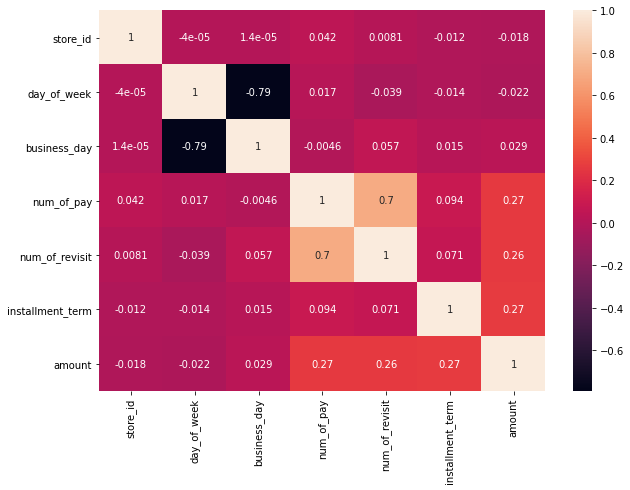

In [154]:
fig,ax=plt.subplots()
fig.set_size_inches(10,7)
sns.heatmap(daily_corr,annot=True)

### Modeling을 위해 Month 단위로 resampling

In [155]:
df_day.head(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2016-06-01,0,2,1,4,4.0,0,NaN,기타 미용업,12571.428571
2016-06-02,0,3,1,7,3.0,0,NaN,기타 미용업,40571.428571
2016-06-03,0,4,1,3,2.0,0,NaN,기타 미용업,18142.857143


In [170]:
df_day.tail(3)

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
transacted_date,,,,,,,,,
2019-02-26,2136,1,1,6,1.0,0,제주 제주시,기타 주점업,47142.857143
2019-02-27,2136,2,1,10,1.0,0,제주 제주시,기타 주점업,65071.428571
2019-02-28,2136,3,1,15,7.0,0,제주 제주시,기타 주점업,65857.142857


In [164]:
from dateutil.relativedelta import relativedelta

In [212]:
df_day[df_day.store_id==0].index[0] 

Timestamp('2016-06-01 00:00:00')

In [218]:
# 2016-06-01 에서 한달전 데이터는 2016-05-01
df_day[df_day.store_id==0].index[0] - relativedelta(months=1)

Timestamp('2016-05-01 00:00:00')

In [172]:
# pd.date_range에 시작날짜와 끝 날짜 지정.
pd.date_range("2018-4-1", "2018-4-5")

DatetimeIndex(['2018-04-01', '2018-04-02', '2018-04-03', '2018-04-04',
               '2018-04-05'],
              dtype='datetime64[ns]', freq='D')

In [165]:
# 2016-06-01 로부터 한달 전
pd.date_range(start=(df_day[df_day.store_id==0].index[0] - relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[0]- relativedelta(months=1)))

DatetimeIndex(['2016-05-01'], dtype='datetime64[ns]', freq='D')

In [171]:
# 2019-02-28 로부터 한달 후
pd.date_range(start=(df_day[df_day.store_id==0].index[-1] + relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[-1]+ relativedelta(months=1)))

DatetimeIndex(['2019-03-28'], dtype='datetime64[ns]', freq='D')

In [174]:
# 한달전, 한달후 row를 위아래로 추가.
pd.concat([pd.DataFrame(index=pd.date_range(start=(df_day[df_day.store_id==0].index[0] - relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[0] - relativedelta(months=1)))),
          df_day[df_day.store_id==0], 
          pd.DataFrame(index=pd.date_range(start=(df_day[df_day.store_id==0].index[-1] + relativedelta(months=1)), end=(df_day[df_day.store_id==0].index[-1]+ relativedelta(months=1))))])

,store_id,day_of_week,business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
2016-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-06-01,0.0,2.0,1.0,4.0,4.0,0.0,NaN,기타 미용업,12571.428571
2016-06-02,0.0,3.0,1.0,7.0,3.0,0.0,NaN,기타 미용업,40571.428571
2016-06-03,0.0,4.0,1.0,3.0,2.0,0.0,NaN,기타 미용업,18142.857143
2016-06-04,0.0,5.0,0.0,7.0,3.0,0.0,NaN,기타 미용업,31714.285714
...,...,...,...,...,...,...,...,...,...
2019-02-25,0.0,0.0,1.0,6.0,3.0,3.0,NaN,기타 미용업,39714.285714
2019-02-26,0.0,1.0,1.0,0.0,0.0,0.0,NaN,기타 미용업,0.000000
2019-02-27,0.0,2.0,1.0,5.0,2.0,0.0,NaN,기타 미용업,9857.142857
2019-02-28,0.0,3.0,1.0,6.0,4.0,0.0,NaN,기타 미용업,22714.285714


In [208]:
# day_of_week(요일) 데이터가 기존에는 일별로 되어있었음.
df_day[df_day.store_id==0][df_day[df_day.store_id==0].amount!=0].day_of_week[:10]

transacted_date
2016-06-01    2
2016-06-02    3
2016-06-03    4
2016-06-04    5
2016-06-05    6
2016-06-06    0
2016-06-09    3
2016-06-10    4
2016-06-11    5
2016-06-12    6
Name: day_of_week, dtype: int64

In [205]:
# day_of_week(요일) 데이터를 월별로 카운트
df_day[df_day.store_id==0][df_day[df_day.store_id==0].amount!=0].day_of_week.resample(rule='m').count().rename('real_tot_day')[:10]  

transacted_date
2016-06-30    25
2016-07-31    26
2016-08-31    24
2016-09-30    25
2016-10-31    26
2016-11-30    23
2016-12-31    27
2017-01-31    20
2017-02-28    23
2017-03-31    23
Freq: M, Name: real_tot_day, dtype: int64

In [210]:
# 한달 간의 평일수 합계 (주말 제외)
df_day[df_day.store_id==0][df_day[df_day.store_id==0].amount!=0].business_day.resample(rule='m').sum().rename('real_business_day')[:10]  

transacted_date
2016-06-30    17
2016-07-31    16
2016-08-31    16
2016-09-30    19
2016-10-31    16
2016-11-30    15
2016-12-31    18
2017-01-31    15
2017-02-28    15
2017-03-31    15
Freq: M, Name: real_business_day, dtype: int64

In [239]:
df_day[df_day.store_id==0].index[0].strftime('%Y-%m')

'2016-06'

In [224]:
import datetime as dt

In [240]:
### 질문 => 한달전, 한달후 row를 추가하는이유 ? 
##### sum해도 되는것들은 그냥 월별로 집계했고, 실제 매출이 발생한 요일수랑 working day 수 구할때만 고려한 이유.
def resample_month(frame_day):
    sum_cols=['num_of_pay','num_of_revisit','installment_term','amount']
    
    df_monthly=pd.DataFrame()
    
    for i in frame_day.store_id.unique():
        df_set=frame_day[frame_day.store_id==i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date= pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0]- relativedelta(months=1)))    # start와 end날짜가 같으면 날짜 하나만 나옴.
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)
        
        ### 이부분 에러나서 수정 : df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1    =====> df_set.loc[df_set.index[0].strftime( '%Y-%m'), :] = 1 
        df_set.loc[df_set.index[0].strftime( '%Y-%m'), :] = 1    # 한달 이전값들을 모두 1로 
        df_set.loc[df_set.index[-1].strftime('%Y-%m'), :] = 1    # 한달 이후값들을 모두 1로
        
        tot_day=df_set[df_set.amount!=0].day_of_week.resample(rule='m').count().rename('real_tot_day') # 매출이 0제외 후, 실제 매출이 발생한 요일 수만 카운트.(즉,30일보다 작을수있음)
        business=df_set[df_set.amount!=0].business_day.resample(rule='m').sum().rename('real_business_day') # 주말 제외한 평일(working day) 수 합계
        
        # 새로 추가한 한달전, 한달 후 데이터를 drop
        business= business.drop([business.index[0], business.index[-1]], axis=0)   # 새로추가한 한달전 row와 한달후 row를 삭제
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0) 
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)
        
        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()],axis=1)
        
        df.insert(0, 'store_id',i)    # 첫번째 컬럼에 store_id값 넣음
        df.insert(6, 'region', df_set.region.values[0])   # 일곱번째 컬럼에 region값 넣음.
        df.insert(7, 'type_of_business',df_set.type_of_business.values[0])
        
        df_monthly= pd.concat([df_monthly, df],axis=0)   # dataframe으로 만들어놓은 df_monthly변수와 concat으로 붙여서 최종셋 만듬.
    return df_monthly

In [228]:
def resample_month(frame_day):
    sum_cols = ['num_of_pay', 'num_of_revisit', 'installment_term', 'amount']

    df_monthly = pd.DataFrame()

    for i in frame_day.store_id.unique():
        df_set = frame_day[frame_day.store_id == i]
        
        # nan값이 발생하는 경우를 없애기 위해 이전, 이후 달에 대한 정보를 추가한 후 제거
        prev_date = pd.date_range(start=(df_set.index[0] - relativedelta(months=1)), end=(df_set.index[0] - relativedelta(months=1)))
        add_date = pd.date_range(start=(df_set.index[-1] + relativedelta(months=1)), end=(df_set.index[-1] + relativedelta(months=1)))
        df_set = pd.concat([pd.DataFrame(index=prev_date), df_set, pd.DataFrame(index=add_date)], axis=0)

        df_set.loc[dt.strftime(df_set.index[0], '%Y-%m'), :] = 1
        df_set.loc[dt.strftime(df_set.index[-1], '%Y-%m'), :] = 1

        tot_day = df_set[df_set.amount != 0].day_of_week.resample(rule='m').count().rename('real_tot_day')
        business = df_set[df_set.amount != 0].business_day.resample(rule='m').sum().rename('real_business_day')

        business = business.drop([business.index[0], business.index[-1]], axis=0)
        tot_day = tot_day.drop([tot_day.index[0], tot_day.index[-1]], axis=0)
        df_set = df_set.drop([df_set.index[0], df_set.index[-1]], axis=0)

        df = pd.concat([tot_day, business, df_set[sum_cols].resample(rule='m').sum()], axis=1)

        df.insert(0, 'store_id', i)
        df.insert(6, 'region', df_set.region.values[0])
        df.insert(7, 'type_of_business', df_set.type_of_business.values[0])

        df_monthly = pd.concat([df_monthly, df], axis=0)
   
    return df_monthly

In [241]:
df_month = resample_month(df_day)

In [242]:
df_month

,store_id,real_tot_day,real_business_day,num_of_pay,num_of_revisit,installment_term,region,type_of_business,amount
2016-06-30,0,25,17.0,145.0,77.0,13.0,NaN,기타 미용업,7.470000e+05
2016-07-31,0,26,16.0,178.0,105.0,24.0,NaN,기타 미용업,1.005000e+06
2016-08-31,0,24,16.0,171.0,97.0,69.0,NaN,기타 미용업,8.715714e+05
2016-09-30,0,25,19.0,160.0,103.0,15.0,NaN,기타 미용업,8.978571e+05
2016-10-31,0,26,16.0,167.0,115.0,9.0,NaN,기타 미용업,8.354286e+05
...,...,...,...,...,...,...,...,...,...
2018-10-31,2136,31,23.0,338.0,86.0,0.0,제주 제주시,기타 주점업,2.012214e+06
2018-11-30,2136,28,20.0,356.0,87.0,0.0,제주 제주시,기타 주점업,2.135429e+06
2018-12-31,2136,31,21.0,403.0,109.0,0.0,제주 제주시,기타 주점업,2.427429e+06
2019-01-31,2136,31,23.0,297.0,74.0,3.0,제주 제주시,기타 주점업,1.873643e+06
